# Libraries

In [ ]:
# Install required library
!pip install datasets

In [27]:
# =========================
# Library Imports
# =========================
import re
import string
import collections
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# =========================
# NLTK Resource Download
# =========================
def download_nltk_resources():
    resources = [
        "stopwords",
        "punkt",
        "omw-1.4",
        "wordnet",
        "punkt_tab",
    ]
    for resource in resources:
        try:
            nltk.data.find(resource)
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Load data

In [ ]:
# =========================
# Dataset Loading
# =========================
from datasets import load_dataset

# Load the Emotion dataset from Hugging Face
emotion_data = load_dataset("emotion")

# Convert splits to pandas DataFrames
train_df = emotion_data["train"].to_pandas()
val_df = emotion_data["validation"].to_pandas()
test_df = emotion_data["test"].to_pandas()

# =========================
# Dataset Merging
# =========================
# Merge training and validation sets for final training
train_df = pd.concat([train_df, val_df], ignore_index=True)


In [8]:
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
train_df.head(10)

Train size: 18000
Test size: 2000


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [9]:
train_df["label"].value_counts(normalize=True)

,proportion
label,
1,0.337000
0,0.289778
3,0.135222
4,0.119389
2,0.082333
5,0.036278


# Preprocess

In [11]:
def clean_text(text):
    """
    Clean and preprocess raw text data for NLP tasks.

    Steps:
    1. Convert text to lowercase
    2. Remove URLs
    3. Remove HTML tags
    4. Remove emojis and special unicode symbols
    5. Remove non-alphabetic characters
    6. Tokenize text
    7. Remove stopwords
    8. Lemmatize tokens
    9. Reconstruct cleaned text

    Parameters
    ----------
    text : str
        Input raw text string.

    Returns
    -------
    str
        Cleaned and preprocessed text.
    """

    # Convert text to lowercase for normalization
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Define emoji and symbol pattern
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    # Remove emojis and unicode symbols
    text = emoji_pattern.sub("", text)

    # Remove non-alphabetic characters and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenize the cleaned text
    tokens = word_tokenize(text)

    # Load English stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Reconstruct cleaned text
    cleaned_text = " ".join(tokens)

    return cleaned_text


In [13]:
# =========================
# Binary Class Filtering
# =========================
# Keep only samples belonging to classes 0 and 1

train_dff = train_df[train_df["label"].isin([0, 1])]
test_df = test_df[test_df["label"].isin([0, 1])]


In [14]:
print("Train label distribution:")
print(train_dff["label"].value_counts())

print("\nTest label distribution:")
print(test_df["label"].value_counts())

Train label distribution:
label
1    6066
0    5216
Name: count, dtype: int64

Test label distribution:
label
1    695
0    581
Name: count, dtype: int64


In [ ]:
# =========================
# Text Preprocessing
# =========================
# Apply text cleaning function to training and test datasets

train_dff["text"] = train_dff["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)


In [16]:
# =========================
# Feature Extraction (TF-IDF)
# =========================
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on training text data
tfidf_vectorizer.fit(train_dff["text"])

# Transform training and test text into TF-IDF feature matrices
X_train_tfidf = tfidf_vectorizer.transform(train_dff["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])

# =========================
# Label Preparation
# =========================
# Extract target labels for training and testing
y_train = train_dff["label"]
y_test = test_df["label"]


# Training

In [ ]:
# =========================
# Model Training (Bernoulli Naive Bayes)
# =========================
# Initialize the Bernoulli Naive Bayes classifier
clf = BernoulliNB()

# Train the model on TF-IDF features
clf.fit(X_train_tfidf, y_train)


# Test

In [21]:
# =========================
# Model Evaluation
# =========================
# Generate predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Compute accuracy
accuracy = np.mean(y_pred == y_test)

# Display evaluation result
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9687


# Evaluation

In [31]:
# =========================
# Evaluation Metrics (Manual Implementation)
# =========================

def precision(y_true, y_pred):
    """
    Compute precision manually.

    Precision = TP / (TP + FP)

    Parameters
    ----------
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.

    Returns
    -------
    float
        Precision score.
    """
    true_positives = sum((y_true == 1) & (y_pred == 1))
    predicted_positives = sum(y_pred == 1)

    if predicted_positives == 0:
        return 0.0

    return true_positives / predicted_positives


def recall(y_true, y_pred):
    """
    Compute recall manually.

    Recall = TP / (TP + FN)

    Parameters
    ----------
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.

    Returns
    -------
    float
        Recall score.
    """
    true_positives = sum((y_true == 1) & (y_pred == 1))
    actual_positives = sum(y_true == 1)

    if actual_positives == 0:
        return 0.0

    return true_positives / actual_positives


def f_measure(y_true, y_pred):
    """
    Compute F1-score manually.

    F1 = 2 * (Precision * Recall) / (Precision + Recall)

    Parameters
    ----------
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.

    Returns
    -------
    float
        F1-score.
    """
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)

    if precision_val + recall_val == 0:
        return 0.0

    return 2 * (precision_val * recall_val) / (precision_val + recall_val)


def confusion_matrix_manual(y_true, y_pred):
    """
    Compute confusion matrix manually.

    Returns matrix in the form:
    [[TN, FP],
     [FN, TP]]

    Parameters
    ----------
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.

    Returns
    -------
    np.ndarray
        2x2 confusion matrix.
    """
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))

    return np.array([[tn, fp], [fn, tp]])

# Compare implemented precision with sklearn
pres = precision(y_test, y_pred)
sklearn_precision = precision_score(y_test, y_pred)

print(f"Implemented Precision: {pres:.4f}")
print(f"Sklearn Precision:     {sklearn_precision:.4f}")

# Compare implemented recall with sklearn
rec = recall(y_test, y_pred)
sklearn_recall = recall_score(y_test, y_pred)

print(f"Implemented Recall:    {rec:.4f}")
print(f"Sklearn Recall:        {sklearn_recall:.4f}")

# Compare implemented F1-score with sklearn
f_meas = f_measure(y_test, y_pred)
sklearn_f_measure = f1_score(y_test, y_pred)

print(f"Implemented F-measure: {f_meas:.4f}")
print(f"Sklearn F-measure:     {sklearn_f_measure:.4f}")

# Compare implemented confusion matrix with sklearn
conf_mat = confusion_matrix_manual(y_test, y_pred)
sklearn_conf_mat = confusion_matrix(y_test, y_pred)

print(f"Implemented Confusion Matrix:\n{conf_mat}")
print(f"Sklearn Confusion Matrix:\n{sklearn_conf_mat}")


Implemented Precision: 0.9645
Sklearn Precision:     0.9645
Implemented Recall:    0.9784
Sklearn Recall:        0.9784
Implemented F-measure: 0.9714
Sklearn F-measure:     0.9714
Implemented Confusion Matrix:
[[556  25]
 [ 15 680]]
Sklearn Confusion Matrix:
[[556  25]
 [ 15 680]]


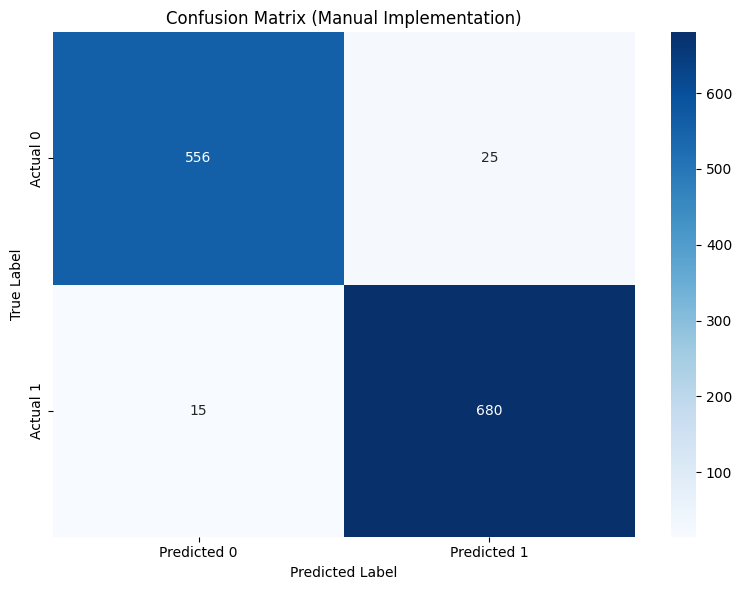

In [32]:
# =========================
# Confusion Matrix Visualization
# =========================
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)

plt.title("Confusion Matrix (Manual Implementation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
